In [9]:
from utils import (
    load_data, 
    station_info, 
    halfspace_inversion,
    multilayer_inversion,
) 
import pandas as pd
import numpy as np
from SimPEG import maps
import matplotlib.pyplot as plt

In [2]:
# Load data
data_directory = '../usapdc_601373/SkyTEM2018_dat.xyz'
data_file, data_keys, std_keys = load_data(data_directory)

# select which line to invert
line_no = 21415



# load in inversion file
inv_directory = '../usapdc_601373/SkyTEM2018_inv.xyz'
inv_file = pd.read_csv(inv_directory, skiprows=7, sep='\s+', escapechar='/')

# trim white space from first column
inv_file.columns = inv_file.columns.str.strip()

In [160]:
# Save-file stuff
save_flag = True
save_filename = "ANTAEM-SimPEG_inv.csv"


In [ ]:
# get line data and group high moment (2)
line_grouping = data_file.groupby('LINE_NO')
line = line_grouping.get_group(line_no)
hm_line = line.groupby('SEGMENT').get_group(2)

thickness = inv_file[inv_file.keys()[35:-1]].to_numpy()[0]

cols = (inv_file.columns.tolist() + ["PCT_DIFF"])
inv_data = []

for station in hm_line.RECORD:
    line_data = hm_line[hm_line.RECORD == station]
    
    UTM_coords = np.array([line_data.UTMX.iloc[0], line_data.UTMY.iloc[0]])
    elevation = line_data.ELEVATION.iloc[0]
    
    srv, data_container = station_info(data_file, data_keys, std_keys, line_no, station)

    background_model = halfspace_inversion(data_file, data_keys, std_keys, line_no, station)
    
    m_final, d_final, percent_err, DOI = multilayer_inversion(background_model,srv,data_container,n_layers=30)
    
    sigma = maps.ExpMap() * m_final
    
    rho = np.concatenate((1/sigma, [1/sigma[-1]]))
    
    inv_results = np.concatenate([[line_no], UTM_coords, [station], [elevation], rho, thickness, [DOI], [percent_err]])
    
    data = zip(cols,inv_results)
    inv_data.append(
        {key: value for key, value in data}
    )
    
df = pd.DataFrame(inv_data,columns=cols)

In [7]:
if save_flag:
    df.to_csv(save_filename)

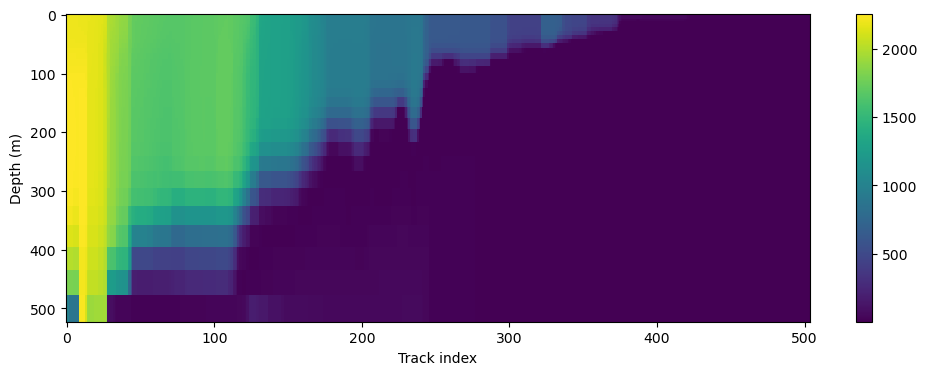

In [208]:
inv_rhos_line = inv_file.groupby('LINE_NO').get_group(line_no)[inv_file.keys()[5:35]].values.T



fig, ax = plt.subplots(1,1,figsize=(12,4))
im = ax.pcolormesh(X,Y,inv_rhos_line,vmin=np.min(inv_rhos_line), vmax=np.max(inv_rhos_line), shading='auto')
ax.invert_yaxis()
ax.set_ylabel("Depth (m)")
ax.set_xlabel("Track index")
fig.colorbar(im, ax=ax)
if save_flag:
    plt.savefig('1d_stitch_inv.eps', format='eps')

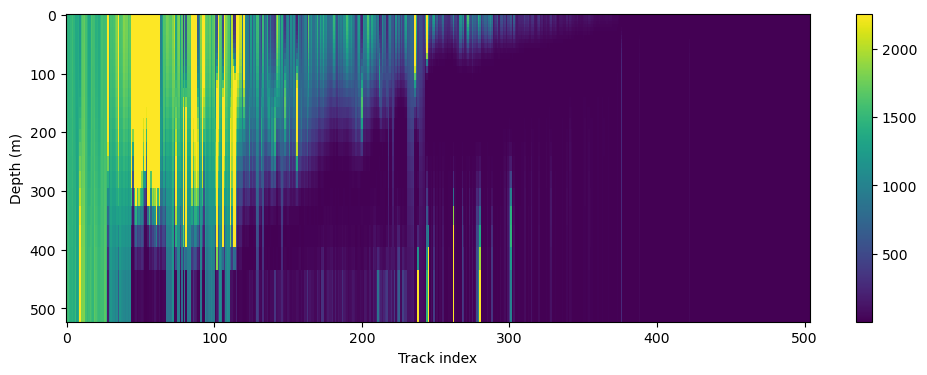

In [165]:
rhos = df[df.keys()[5:35]].values.T
depth = np.hstack((0,df.values[0][35:-2].cumsum()))
X, Y = np.meshgrid(df.index, depth)

fig, ax = plt.subplots(1,1,figsize=(12,4))
im = ax.pcolormesh(X,Y,rhos,vmin=np.min(inv_rhos_line), vmax=np.max(inv_rhos_line), shading='auto')

ax.invert_yaxis()
ax.set_ylabel("Depth (m)")
ax.set_xlabel("Track index")
fig.colorbar(im, ax=ax)
if save_flag:
    plt.savefig('1d_stitch_model.eps', format='eps')

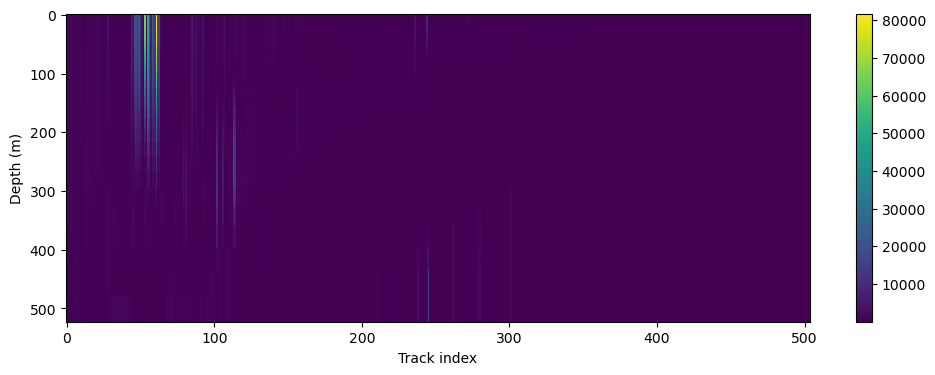

In [156]:
fig, ax = plt.subplots(1,1,figsize=(12,4))
im = ax.pcolormesh(X,Y,abs(inv_rhos_line-rhos), shading='auto')
ax.invert_yaxis()
ax.set_ylabel("Depth (m)")
ax.set_xlabel("Track index")
fig.colorbar(im, ax=ax)